<a href="https://colab.research.google.com/github/UTakeuchi/PDsimulator/blob/main/main_case2_dqn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install dezero # 初回のみ

In [1]:
from collections import defaultdict
import copy
from collections import deque
import random
import numpy as np
import matplotlib.pyplot as plt
from dezero import Model
from dezero import optimizers
import dezero.functions as F
import dezero.layers as L

# DQNエージェント

In [2]:
class ReplayBuffer:
    def __init__(self, buffer_size, batch_size):
        self.buffer = deque(maxlen=buffer_size)
        self.batch_size = batch_size

    def add(self, state, action, reward, next_state, done):
        data = (state, action, reward, next_state, done)
        self.buffer.append(data)

    def __len__(self):
        return len(self.buffer)

    def get_batch(self):
        data = random.sample(self.buffer, self.batch_size)

        state = np.stack([x[0] for x in data])
        action = np.array([x[1] for x in data])
        reward = np.array([x[2] for x in data])
        next_state = np.stack([x[3] for x in data])
        done = np.array([x[4] for x in data]).astype(np.int32)
        return state, action, reward, next_state, done

class QNet(Model):
    def __init__(self, action_size):
        super().__init__()
        # self.l1 = L.Linear(128)
        self.l2 = L.Linear(128)
        self.l3 = L.Linear(action_size)

    def forward(self, x):
        # x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = self.l3(x)
        return x


class DQNAgent:
    def __init__(self):
        self.gamma = 0.98
        self.lr = 0.0005
        self.epsilon = 0.1
        self.buffer_size = 10000
        self.batch_size = 32
        self.action_size = 2

        self.replay_buffer = ReplayBuffer(self.buffer_size, self.batch_size)
        self.qnet = QNet(self.action_size)
        self.qnet_target = QNet(self.action_size)
        self.optimizer = optimizers.Adam(self.lr)
        self.optimizer.setup(self.qnet)

    def get_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.action_size)
        else:
            state = state[np.newaxis, :]
            qs = self.qnet(state)
            return qs.data.argmax()

    def update(self, state, action, reward, next_state, done=False):
        self.replay_buffer.add(state, action, reward, next_state, done)
        if len(self.replay_buffer) < self.batch_size:
            return

        state, action, reward, next_state, done = self.replay_buffer.get_batch()
        qs = self.qnet(state)
        q = qs[np.arange(self.batch_size), action]

        next_qs = self.qnet_target(next_state)
        next_q = next_qs.max(axis=1)
        next_q.unchain()
        target = reward + (1 - done) * self.gamma * next_q

        loss = F.mean_squared_error(q, target)

        self.qnet.cleargrads()
        loss.backward()
        self.optimizer.update()

    def sync_qnet(self):
        self.qnet_target = copy.deepcopy(self.qnet)

# Prisoner's dillema game

In [3]:
class PDGame:
    def __init__(self):
        self.action_space = [0, 1]
        self.action_meaning = {
            0: "Defect",
            1: "Cooperate",
        }
        self.b = 5 #benefit
        self.c = 1 #cost
    
    def matching(self, agents):
        pairs = len(agents) // 2
        return np.random.choice(agents, size=(pairs, 2), replace=False) # agentの番号を返す
        
    def step(self, a1, a2):
        u1 = {(1, 1):self.b - self.c, (1, 0):-self.c, (0, 1):self.b, (0, 0):0}
        u2 = {(1, 1):self.b - self.c, (1, 0):self.b, (0, 1):-self.c, (0, 0):0}
        return u1[(a1,a2)], u2[(a1,a2)]

# シミュレーションの実行

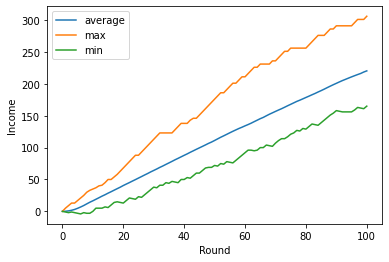

In [13]:
env = PDGame()
n = 100 # agentの人数 n
agents = []
for i in range(n):
    agents.append(DQNAgent())
incomes = np.zeros(n) # 所得はAgents()の外部に格納
income_history = np.zeros((3,1)) # 各行に平均値・最大値・最小値の推移を格納

rounds = 100
sync_interval = 20
for round in range(rounds):
    players = env.matching(range(len(agents)))
    for pair in players:
        x, y = pair
        player1, player2 = agents[x], agents[y]
        state = np.array([incomes[x], incomes[y]]) #stateは（自分の所得, 相手の所得）の順にする
    
        a1 = player1.get_action(state)
        a2 = player2.get_action(state[::-1]) #player2目線に変換
        r1, r2 = env.step(a1, a2)
        incomes[x] += r1
        incomes[y] += r2
        next_state = np.array([incomes[x], incomes[y]])
        player1.update(state, a1, r1, next_state)
        player2.update(state[::-1], a2, r2, next_state[::-1])
    
    if round % sync_interval == 0:
        for agent in agents:
            agent.sync_qnet()

    add = np.array([[np.mean(incomes)], [incomes.max()], [incomes.min()]])
    income_history = np.append(income_history, add, axis=1)

# rand = np.random.randint(0, n)
# for i in range(n):
#     if i == rand:
#         print("----------agent{}'s policy-----------".format(i+1))
#         for key, value in agents[i].pi.items():
#             print('state:{}, policy:{}'.format(key, value))
#         print('policy number = ' + str(len(agents[i].pi)))

def plot_total_income(history):
    plt.xlabel('Round')
    plt.ylabel('Income')
    plt.plot(range(len(history[0])), history[0], label='average')
    plt.plot(range(len(history[1])), history[1], label='max')
    plt.plot(range(len(history[2])), history[2], label='min')
    plt.legend()
    plt.show()

plot_total_income(income_history)

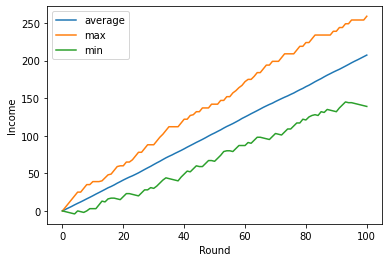

In [17]:
# 学習後のテストフェーズ
incomes = np.zeros(n) # 所得を初期化
income_history = np.zeros((3,1)) # 各行に平均値・最大値・最小値の推移を格納

rounds = 100
sync_interval = 20
for round in range(rounds):
    players = env.matching(range(len(agents)))
    for pair in players:
        x, y = pair
        player1, player2 = agents[x], agents[y]
        state = np.array([incomes[x], incomes[y]]) #stateは（自分の所得, 相手の所得）の順にする
    
        a1 = player1.get_action(state)
        a2 = player2.get_action(state[::-1]) #player2目線に変換
        r1, r2 = env.step(a1, a2)
        incomes[x] += r1
        incomes[y] += r2
        # next_state = np.array([incomes[x], incomes[y]])
        # player1.update(state, a1, r1, next_state)
        # player2.update(state[::-1], a2, r2, next_state[::-1])

    add = np.array([[np.mean(incomes)], [incomes.max()], [incomes.min()]])
    income_history = np.append(income_history, add, axis=1)

def plot_total_income(history):
    plt.xlabel('Round')
    plt.ylabel('Income')
    plt.plot(range(len(history[0])), history[0], label='average')
    plt.plot(range(len(history[1])), history[1], label='max')
    plt.plot(range(len(history[2])), history[2], label='min')
    plt.legend()
    plt.show()

plot_total_income(income_history)